# Algorithmic Fairness, Accountability, and Ethics, Spring 2023
# Exercise 2

## Task 3 (Fairness/Utility-Tradeoff)

**Remark:** You might find it easier to solve this task by writing some code.

Look at the following two picture that presents group and target as usual, but instead of seeing the outcome of the selection, we just see the score. (You can think about it as the grade point average achieved in school.)

<img src="002.png" width="600">

We discuss a classifier that selects all individuals above a certain (maybe group-specific) threshold.

1) Sketch the ROC curve for a threshold based classifier (or actually plot it).
2) Let us say that we are in a situation where a false positive costs us 150 DKK, a true positive gives us 100 DKK.
    - If we want to maximize the profit using a single threshold, which one would it be?
    - If we want to achieve statistical parity by choosing individual threshold values, which thresholds can we choose? Which one provides the best utility, i.e., the largest profit? 
    - At which individual thresholds do you achieve equalized odds in this setting? Which setting achieves the best utility?

## Practical exercise

In this exercise, we will work with a very recently published dataset that collects data from the US Census 2020. The dataset and a description is available at <https://github.com/zykls/folktables>. The features names are described in the appendix of the accompanying paper at <https://arxiv.org/pdf/2108.04884.pdf>.

The goal of this exercise is to prepare mandatory assignment 1, in which you will further explore the dataset in terms of fairness and interpretability.


### Setup

In [1]:
# Import modules
import numpy as np
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Define group, target, and score for each shape
group = [0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1]
target = [1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0]
score = [9.7, 9.0, 9.5, 7.6, 9.1, 10.1, 6.8, 8.8, 6.7, 6.6, 6.4, 7.5]

# Divide data into the two groups
idx_group_1 = group.index(1)
group_0 = group[:idx_group_1]
group_1 = group[idx_group_1:]
target_0 = target[:idx_group_1]
target_1 = target[idx_group_1:]
score_0 = score[:idx_group_1]
score_1 = score[idx_group_1:]

### Compute and plot the ROC curve

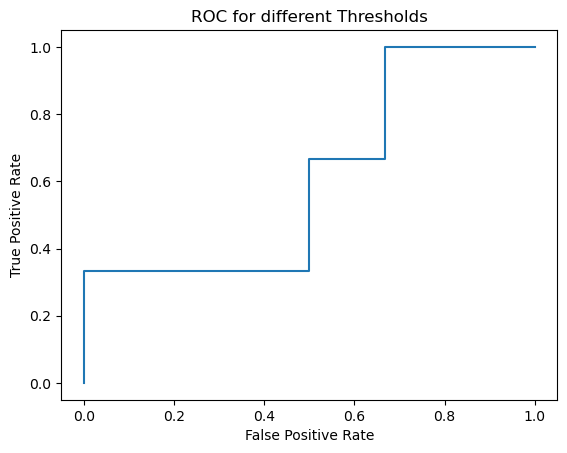

In [3]:
# Compute ROC curve 
fpr, tpr, thr = roc_curve(target, score, drop_intermediate=False)

# Plot it
fig, ax = plt.subplots()
ax.plot(fpr, tpr)
ax.set_title("ROC for different Thresholds")
ax.set_ylabel("True Positive Rate")
ax.set_xlabel("False Positive Rate")
plt.show()

### Let's make some money

In [5]:
# Compute n_positives (we'll need this later)
n_positives = sum(target)

# Find the global threshold which earns us the most money
best_index = 0
best_threshold = 0
money_list = []
most_money = 0
for i in range(len(thr)):
    threshold = thr[i]
    tp = tpr[i] * n_positives
    fp = fpr[i] * n_positives
    money = (tp * 100 - fp * 150)
    money_list.append(money)
    if money > most_money:
        best_index = i
        most_money = money
        best_threshold = threshold

print(f'Best index: {best_index}, Best threshold: {best_threshold}, Most money: {most_money}', sep='\n')

Best index: 2, Best threshold: 9.7, Most money: 200.0


### Let's make some money while maintaining statistical parity

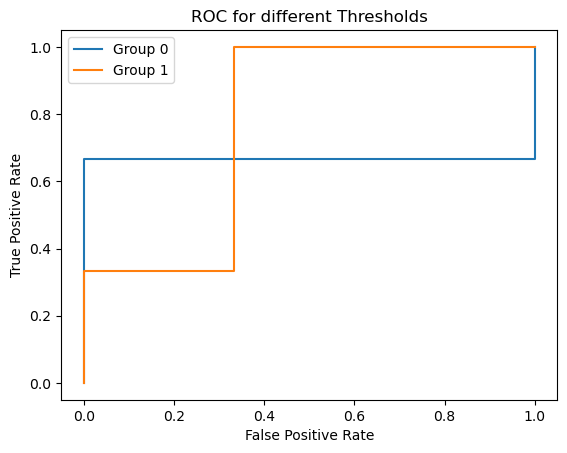

In [6]:
# Compute seperate ROC curves for the two groups
fpr_0, tpr_0, thr_0 = roc_curve(target_0, score_0, drop_intermediate=False)
fpr_1, tpr_1, thr_1 = roc_curve(target_1, score_1, drop_intermediate=False)

# Plot them
fig, ax = plt.subplots()

ax.plot(fpr_0, tpr_0, label='Group 0')
ax.plot(fpr_1, tpr_1, label='Group 1')
ax.set_title("ROC for different Thresholds")
ax.set_ylabel("True Positive Rate")
ax.set_xlabel("False Positive Rate")
plt.legend()
plt.show()

In [7]:
# Make money
n_positives_0 = sum(target_0)
n_positives_1 = sum(target_1)

best_index = 0
best_threshold_0 = 0
best_threshold_1 = 0
most_money = 0

for i in range(len(group_0)):
    threshold_0 = thr_0[i]
    threshold_1 = thr_1[i]
    tp_0 = tpr_0[i] * n_positives_0
    fp_0 = fpr_0[i] * n_positives_0
    tp_1 = tpr_1[i] * n_positives_1
    fp_1 = fpr_1[i] * n_positives_1
    money = (tp_0 * 100 - fp_0 * 150) + (tp_1 * 100 - fp_1 * 150)
    if money > most_money:
        best_index = i
        most_money = money
        best_threshold_0 = threshold_0
        best_threshold_1 = threshold_1


print(f'Best index: {best_index}\nBest threshold group 0: {best_threshold_0}\nBest threshold group 1: {best_threshold_1}\nMost money with statistical parity: {most_money}')

Best index: 1
Best threshold group 0: 10.1
Best threshold group 1: 8.8
Most money with statistical parity: 200.0


### Let's make some money while maintaining equalized odds

In [8]:
money_array = np.zeros((len(thr_0), len(thr_1))) # Just to see how much money we could have made setting individual group thresholds without caring about fairness

best_index_0 = 0
best_index_1 = 0
best_threshold_0 = 0
best_threshold_1 = 0
most_money = 0
for i, thr_0_i in enumerate(thr_0):
    tpr_0_i = tpr_0[i]
    fpr_0_i = fpr_0[i]
    tp_0_i = tpr_0_i * n_positives_0
    fp_0_i = fpr_0_i * n_positives_0
    for j, thr_1_j in enumerate(thr_1):
        tpr_1_j = tpr_1[j]
        fpr_1_j = fpr_1[j]
        tp_1_j = tpr_1_j * n_positives_1
        fp_1_j = fpr_1_j * n_positives_1
        
        money = (tp_0_i * 100 - fp_0_i * 150) + (tp_1_j * 100 - fp_1_j * 150)
        money_array[i, j] = money
        
        if (money > most_money) & (tpr_0_i==tpr_1_j) & (fpr_0_i==fpr_1_j):
            best_index_0 = i
            best_index_1 = j
            most_money = money
            best_threshold_0 = thr_0_i
            best_threshold_1 = thr_1_j

print(f'Best index 0: {best_index_0}\nBest index 1: {best_index_1}\nBest threshold 0: {best_threshold_0}\nBest threshold 1: {best_threshold_1}\nMost money: {most_money}')

Best index 0: 1
Best index 1: 1
Best threshold 0: 10.1
Best threshold 1: 8.8
Most money: 200.0


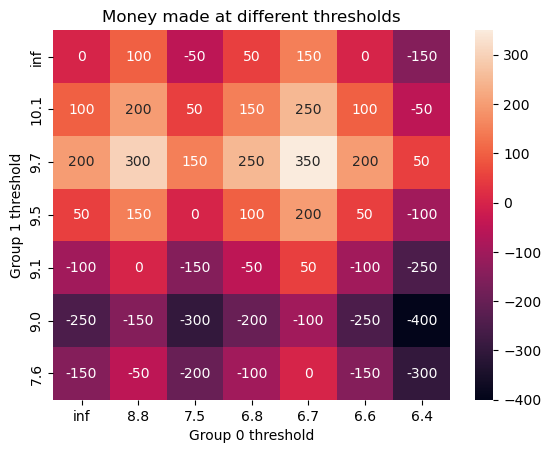

In [11]:
# Plot money array (no fairness constructs)
fig, ax = plt.subplots()
sns.heatmap(money_array, annot=True, fmt='.0f', ax=ax)
ax.set_title("Money made at different thresholds")
ax.set_xlabel("Group 0 threshold")
ax.set_ylabel("Group 1 threshold")
ax.set_yticklabels(thr_0)
ax.set_xticklabels(thr_1)
plt.show()